In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.manifold import TSNE

sns.set_style("darkgrid")
sns.set_context("talk",  font_scale=0.6)

In [2]:
# --- Configuration ---
DTW_PAIRWISE_CSV = "pairwise_dtw_distances_parallel.csv"
FRECHET_PAIRWISE_CSV = "pairwise_frechet_distances_parallel.csv"
DTW_MATRIX_NPY = "dtw_distance_matrix_parallel.npy"
FRECHET_MATRIX_NPY = "frechet_distance_matrix_parallel.npy"

In [3]:
# --- Load Data ---
print("--- Loading Data ---")
try:
    df_dtw = pd.read_csv(DTW_PAIRWISE_CSV)
    print(f"Loaded {len(df_dtw)} DTW pairwise distances.")
except FileNotFoundError:
    print(f"Error: {DTW_PAIRWISE_CSV} not found.")
    exit()

try:
    df_frechet = pd.read_csv(FRECHET_PAIRWISE_CSV)
    print(f"Loaded {len(df_frechet)} Frechet pairwise distances.")
except FileNotFoundError:
    print(f"Error: {FRECHET_PAIRWISE_CSV} not found.")
    exit()

try:
    dtw_matrix = np.load(DTW_MATRIX_NPY)
    print(f"Loaded DTW distance matrix (shape: {dtw_matrix.shape}).")
except FileNotFoundError:
    print(f"Error: {DTW_MATRIX_NPY} not found.")

try:
    frechet_matrix = np.load(FRECHET_MATRIX_NPY)
    print(f"Loaded Frechet distance matrix (shape: {frechet_matrix.shape}).")
except FileNotFoundError:
    print(f"Error: {FRECHET_MATRIX_NPY} not found.")


--- Loading Data ---
Loaded 83436 DTW pairwise distances.
Loaded 83436 Frechet pairwise distances.
Loaded DTW distance matrix (shape: (409, 409)).
Loaded Frechet distance matrix (shape: (409, 409)).


In [4]:
# --- Prepare Data for Merging ---
# Ensure PDB ID pairs are consistently ordered (e.g., PDB1 always < PDB2) for merging
def sort_pdb_pair(row):
    if row['PDB1'] < row['PDB2']:
        return row['PDB1'], row['PDB2']
    else:
        return row['PDB2'], row['PDB1']

df_dtw[['PDB1_Sorted', 'PDB2_Sorted']] = df_dtw.apply(sort_pdb_pair, axis=1, result_type='expand')
df_frechet[['PDB1_Sorted', 'PDB2_Sorted']] = df_frechet.apply(sort_pdb_pair, axis=1, result_type='expand')

# Merge the two dataframes on the sorted PDB pairs
merged_df = pd.merge(df_dtw[['PDB1_Sorted', 'PDB2_Sorted', 'DTW_Distance_Normalized']],
                     df_frechet[['PDB1_Sorted', 'PDB2_Sorted', 'Frechet_Distance']],
                     on=['PDB1_Sorted', 'PDB2_Sorted'],
                     how='inner',
                     suffixes=('_DTW', '_Frechet'))

print(f"\nMerged dataframe head (showing common pairs):")
print(merged_df.head())
print(f"Total common pairs in merged dataframe: {len(merged_df)}")

# Reconstruct pdb_ids_list from the merged dataframe for consistent indexing later
all_pdb_ids_merged = pd.concat([merged_df['PDB1_Sorted'], merged_df['PDB2_Sorted']]).unique()
pdb_ids_list = sorted(list(all_pdb_ids_merged))
print(f"Identified {len(pdb_ids_list)} unique PDB IDs from merged data.")

# Sanity check for matrix dimensions vs. PDB IDs list
if dtw_matrix.shape[0] != len(pdb_ids_list) or frechet_matrix.shape[0] != len(pdb_ids_list):
    print("Warning: Mismatch in matrix dimensions and PDB ID list. Some downstream analysis might fail.")


Merged dataframe head (showing common pairs):
  PDB1_Sorted PDB2_Sorted  DTW_Distance_Normalized  Frechet_Distance
0        1a14        1a6u                68.523586         87.563713
1        1a14        1a7o                63.141872         91.435036
2        1a14        1a7p                62.924609         90.909996
3        1a14        1a7n                63.021827         91.071602
4        1a14        1a6w                50.779034         71.639359
Total common pairs in merged dataframe: 83436
Identified 409 unique PDB IDs from merged data.


# 1. Distance Distribution Comparison

**Criteria:** Compare the shapes, ranges, and central tendencies of their distributions.


--- 1. Distance Distribution Comparison ---


/Users/dvoulgari/Desktop/Structural Bioinfromatics/AISB_Final_Project/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: divide by zero encountered in dot
  c = dot(X, X_T.conj())
/Users/dvoulgari/Desktop/Structural Bioinfromatics/AISB_Final_Project/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: overflow encountered in dot
  c = dot(X, X_T.conj())
/Users/dvoulgari/Desktop/Structural Bioinfromatics/AISB_Final_Project/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: invalid value encountered in dot
  c = dot(X, X_T.conj())
/Users/dvoulgari/Desktop/Structural Bioinfromatics/AISB_Final_Project/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: divide by zero encountered in dot
  c = dot(X, X_T.conj())
/Users/dvoulgari/Desktop/Structural Bioinfromatics/AISB_Final_Project/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_i

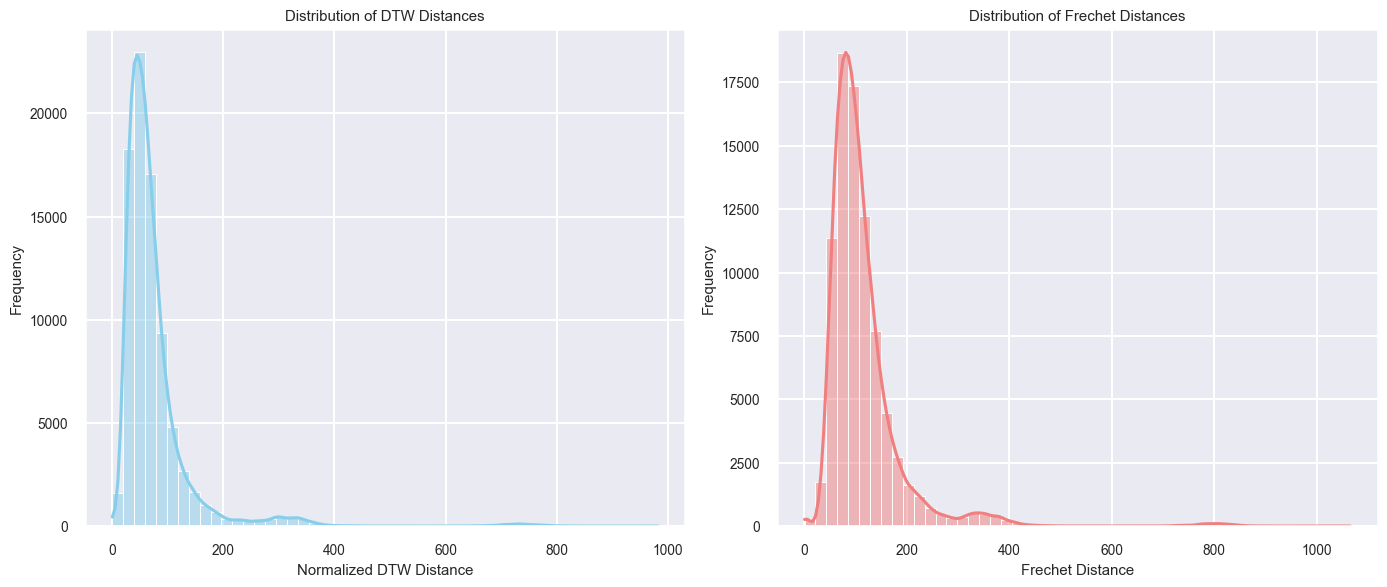


Descriptive Statistics for DTW_Distance_Normalized:
count    83436.000000
mean        74.568947
std         70.476788
min          0.025131
25%         40.060055
50%         57.859811
75%         82.891604
max        982.769830
Name: DTW_Distance_Normalized, dtype: float64

Descriptive Statistics for Frechet_Distance:
count    83436.000000
mean       114.350889
std         77.159541
min          0.276476
25%         72.861935
50%         96.787422
75%        130.155811
max       1065.634766
Name: Frechet_Distance, dtype: float64


In [5]:
print("\n--- 1. Distance Distribution Comparison ---")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(merged_df['DTW_Distance_Normalized'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of DTW Distances')
plt.xlabel('Normalized DTW Distance')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(merged_df['Frechet_Distance'], bins=50, kde=True, color='lightcoral')
plt.title('Distribution of Frechet Distances')
plt.xlabel('Frechet Distance')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nDescriptive Statistics for DTW_Distance_Normalized:")
print(merged_df['DTW_Distance_Normalized'].describe())
print("\nDescriptive Statistics for Frechet_Distance:")
print(merged_df['Frechet_Distance'].describe())

### Insights from Histograms - Interpretation of Distance Distributions

The provided histograms and descriptive statistics allow us to compare how DTW and Frechet distances behave.

1. Distribution Shape:

Both DTW and Frechet distributions are highly right-skewed. This is evident from the long tail extending towards higher distance values in both histograms. The vast majority of distances are concentrated at the lower end.
Presence of a prominent peak: Both distributions show a sharp peak at relatively low distance values, indicating that most antibody pairs exhibit a high degree of structural similarity (or low distance) according to both metrics.

2. Range of Distances:

DTW Distances: Range from 0.025 to 982.77.
Frechet Distances: Range from 0.276 to 1065.63.
Observation: Frechet distances generally span a slightly larger range, particularly at the upper end. The maximum Frechet distance (1065.63) is higher than the maximum DTW distance (982.77).

3. Central Tendency and Spread:

    - `Mean vs. Median:`
DTW: Mean = 74.57, Median = 57.86. The mean is significantly higher than the median, which is a classic indicator of a right-skewed distribution.
Frechet: Mean = 114.35, Median = 96.79. Similarly, the mean is notably higher than the median, confirming its right-skewed nature.

    - `Absolute Values:`
The mean and median Frechet distances are considerably higher than their DTW counterparts (e.g., Frechet mean is ~114 vs. DTW mean is ~75). This suggests that, on average, the Frechet distance assigns larger absolute values for the same pairs compared to DTW. This is expected, as Frechet is a stricter metric that doesn't allow the "warping" that DTW does, often resulting in larger minimum "leash lengths."

    - `Standard Deviation (Spread):`
DTW: Std = 70.48
Frechet: Std = 77.16
Observation: Both standard deviations are relatively large compared to their means, indicating significant variability in distances. Frechet has a slightly larger standard deviation, consistent with its wider range and potentially greater sensitivity to subtle differences not aligned by DTW.

4. Implications:

The higher absolute values for Frechet distances imply that Frechet might be more sensitive to local structural misalignments or subtle shifts that DTW can "warp" around.
The similar highly skewed distribution shapes for both metrics suggest that the vast majority of antibody pairs are quite similar structurally, with only a few pairs showing very large distances.
The distributions indicate that there aren't distinct, clear clusters of highly dissimilar pairs that jump out from these histograms alone (e.g., a bimodal distribution with a clear second peak at a very high distance). Most of the differences are continuous.


In summary, both metrics indicate that most antibody structures are quite similar, but Frechet assigns higher absolute dissimilarity values on average and tends to have a slightly wider range. This initial look suggests they are measuring related aspects of similarity but with different scales and perhaps sensitivities.

# 2. Correlation Analysis

**Criteria:** Quantify the linear and monotonic relationship between the two distance metrics.


--- 2. Correlation Analysis ---
Pearson Correlation (DTW vs Frechet): 0.964 (p-value: 0.000e+00)
Spearman Correlation (DTW vs Frechet): 0.877 (p-value: 0.000e+00)


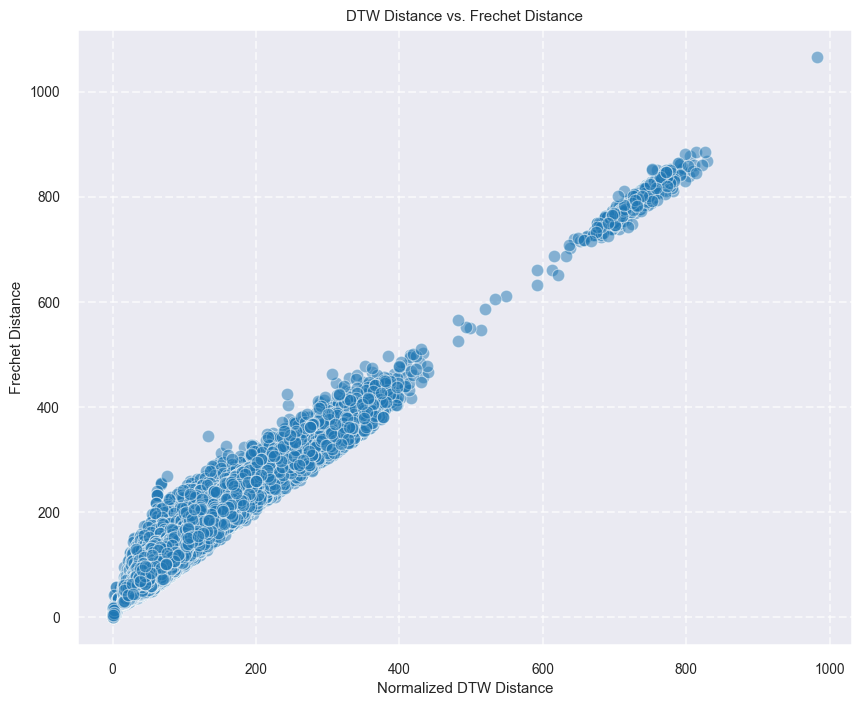

In [6]:
print("\n--- 2. Correlation Analysis ---")

# Pearson Correlation (linear relationship)
pearson_corr, pearson_p = pearsonr(merged_df['DTW_Distance_Normalized'],
                                   merged_df['Frechet_Distance'])
print(f"Pearson Correlation (DTW vs Frechet): {pearson_corr:.3f} (p-value: {pearson_p:.3e})")

# Spearman Rank Correlation (monotonic relationship, robust to outliers)
spearman_corr, spearman_p = spearmanr(merged_df['DTW_Distance_Normalized'],
                                      merged_df['Frechet_Distance'])
print(f"Spearman Correlation (DTW vs Frechet): {spearman_corr:.3f} (p-value: {spearman_p:.3e})")

# Visualization: Scatter Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=merged_df, x='DTW_Distance_Normalized', y='Frechet_Distance', alpha=0.5, hue=None)
plt.title('DTW Distance vs. Frechet Distance')
plt.xlabel('Normalized DTW Distance')
plt.ylabel('Frechet Distance')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Interpretation of Correlation Analysis

The correlation analysis helps us understand the relationship between the Normalized DTW Distance and the Normalized Frechet Distance for the antibody pairs.

1. Pearson Correlation:

Value: 0.964
P-value: 0.000×10^0 (which is effectively 0)

`Interpretation:`

A Pearson correlation coefficient of 0.964 indicates an extremely strong positive linear relationship between DTW and Frechet distances. This means that as the normalized DTW distance between two antibody structures increases, the normalized Frechet distance between them also tends to increase in a very consistent, linear fashion.
The p-value of 0.000e+00 is well below the common significance level of 0.05, indicating that this strong correlation is highly statistically significant and is very unlikely to have occurred by random chance.

2. Spearman Rank Correlation:

Value: 0.877
P-value: 0.000×10^0 (which is effectively 0)

`Interpretation:`

A Spearman rank correlation coefficient of 0.877 indicates a very strong positive monotonic relationship between DTW and Frechet distances. This means that if one pair of antibodies is ranked as more dissimilar by DTW, it is also very likely to be ranked as more dissimilar by Frechet, even if the exact linear scaling is not perfect. Spearman correlation is less sensitive to outliers and non-linear monotonic relationships compared to Pearson.
The p-value of 0.000e+00 again shows that this strong rank correlation is highly statistically significant.

3. Comparison and Overall Insight:

Both Pearson (0.964) and Spearman (0.877) correlations are exceptionally high and statistically significant. This is a crucial finding.
The fact that the Pearson correlation is slightly higher than the Spearman correlation could suggest that the relationship has a very strong linear component, perhaps with some non-linear deviations or a few outliers that slightly reduce the rank correlation. However, the difference is not dramatic.
The high correlations imply that, for the dataset, DTW and Frechet distances largely agree on the overall relative similarity or dissimilarity of antibody structures. If two structures are considered close by DTW, they are almost certainly considered close by Frechet, and vice-versa. This suggests that while their absolute scales might differ (as seen in the descriptive statistics earlier), their underlying assessment of structural relationships is very similar for these particular comparisons.

4. Scatter Plot:

This scatter plot vividly demonstrates a strong positive linear correlation between Normalized DTW and Frechet distances.

- High Agreement: Points are tightly clustered along an upward-sloping line, confirming the very high Pearson (0.964) and Spearman (0.877) correlation coefficients. This indicates that pairs considered similar by DTW are also considered similar by Frechet, and vice-versa.
- Scale Difference: The line's slope appears slightly steeper than 45 degrees, visually confirming that Frechet distances generally assign higher absolute values than DTW distances for the same pairs. This reflects Frechet's stricter "leash" constraint compared to DTW's allowance for warping.
- Distribution Focus: The high density of points towards the origin (lower distances) aligns with the right-skewed histograms, showing that most antibody pairs are structurally quite similar by both metrics.

**Overall:** The plot reinforces that both metrics capture very similar aspects of structural relatedness, with Frechet providing a slightly larger numerical separation. Strong disagreements between the two are rare.

# 3. Agreement on Top/Bottom N Pairs

**Criteria:** Do the metrics identify the same most similar (or most dissimilar) pairs?

In [7]:
print("\n--- 3. Agreement on Top/Bottom N Pairs ---")

N = 20 # Number of top/bottom pairs to consider

# Most Similar (lowest distance)
top_dtw_pairs = merged_df.sort_values('DTW_Distance_Normalized').head(N)[['PDB1_Sorted', 'PDB2_Sorted']]
top_frechet_pairs = merged_df.sort_values('Frechet_Distance').head(N)[['PDB1_Sorted', 'PDB2_Sorted']]

# Convert to sets of frozensets for easy comparison (order of PDBs in pair doesn't matter)
top_dtw_set = set(frozenset(x) for x in top_dtw_pairs.values)
top_frechet_set = set(frozenset(x) for x in top_frechet_pairs.values)

common_top_pairs = top_dtw_set.intersection(top_frechet_set)
print(f"\nTop {N} Most Similar Pairs:")
print(f"  DTW: {len(top_dtw_set)} pairs")
print(f"  Frechet: {len(top_frechet_set)} pairs")
print(f"  Common pairs (overlap): {len(common_top_pairs)} ({len(common_top_pairs)/N*100:.2f}%)")

# Most Dissimilar (highest distance)
bottom_dtw_pairs = merged_df.sort_values('DTW_Distance_Normalized', ascending=False).head(N)[['PDB1_Sorted', 'PDB2_Sorted']]
bottom_frechet_pairs = merged_df.sort_values('Frechet_Distance', ascending=False).head(N)[['PDB1_Sorted', 'PDB2_Sorted']]

bottom_dtw_set = set(frozenset(x) for x in bottom_dtw_pairs.values)
bottom_frechet_set = set(frozenset(x) for x in bottom_frechet_pairs.values)

common_bottom_pairs = bottom_dtw_set.intersection(bottom_frechet_set)
print(f"\nTop {N} Most Dissimilar Pairs:")
print(f"  DTW: {len(bottom_dtw_set)} pairs")
print(f"  Frechet: {len(bottom_frechet_set)} pairs")
print(f"  Common pairs (overlap): {len(common_bottom_pairs)} ({len(common_bottom_pairs)/N*100:.2f}%)")


--- 3. Agreement on Top/Bottom N Pairs ---

Top 20 Most Similar Pairs:
  DTW: 20 pairs
  Frechet: 20 pairs
  Common pairs (overlap): 10 (50.00%)

Top 20 Most Dissimilar Pairs:
  DTW: 20 pairs
  Frechet: 20 pairs
  Common pairs (overlap): 14 (70.00%)


### Insights from Top/Bottom N comparison

This analysis focuses on whether DTW and Frechet distances identify the same specific antibody pairs as being the most or least structurally similar. This is crucial for understanding if the metrics converge on the "extreme" cases.

1. Top 20 Most Similar Pairs:

Overlap: `10 out of 20 pairs (50.00% overlap)`.
Interpretation:

A 50% overlap means that half of the antibody pairs deemed most similar by DTW were also among the top 20 most similar pairs by Frechet distance. This indicates a moderate level of agreement at the very extreme of similarity.
The fact that it's not higher (e.g., 80−90%) suggests that for structures that are very close, the nuances of how each metric calculates "distance" come into play. DTW, with its ability to "warp" or stretch one sequence to match another, might identify certain subtle similarities that Frechet, with its stricter point-to-point correspondence, might penalize more heavily, leading to a slightly different ranking for the absolute closest pairs.

2. Top 20 Most Dissimilar Pairs:

Overlap: `14 out of 20 pairs (70.00% overlap)`.
Interpretation:

A 70% overlap signifies a stronger agreement between DTW and Frechet distances when it comes to identifying the most dissimilar antibody pairs.
This higher percentage suggests that for structures that are truly very different from each other, both the flexibility of DTW's warping and the rigidity of Frechet's leash will converge on recognizing that fundamental dissimilarity. Large structural differences likely overwhelm the methodological nuances that might differentiate their ranking of very similar structures.

**Overall Insights:**

- Asymmetry in Agreement: There's a notable asymmetry in agreement: the metrics agree more strongly on what constitutes "very dissimilar" (70% overlap) than on what constitutes "very similar" (50% overlap).
- Nature of Dissimilarity: This pattern suggests that when structures are highly divergent, both DTW and Frechet are robustly capturing that divergence. However, for subtle similarities, their distinct definitions of path comparison lead to more differentiated rankings.
- Practical Implications: If the goal is to identify the most diverse or outlier antibody structures, both DTW and Frechet are likely to point towards a highly overlapping set of candidates. If we are trying to find the absolute closest matches, we might get slightly different candidates depending on which metric we prioritize, reflecting whether we value alignment with warping (DTW) or strict point-to-point correspondence (Frechet).

# 4. Clustering Consistency

**Criteria:** Do the two distance metrics lead to similar groupings of antibodies?


--- 4. Clustering Consistency ---
DTW Cluster Counts (5 clusters):
1    400
0      6
3      1
4      1
2      1
Name: count, dtype: int64

Frechet Cluster Counts (5 clusters):
1    402
2      3
0      2
3      1
4      1
Name: count, dtype: int64

Adjusted Rand Index (ARI) between DTW and Frechet clusters: 0.869
Normalized Mutual Information (NMI) between DTW and Frechet clusters: 0.782

Visualizing t-SNE projections colored by DTW and Frechet clusters...


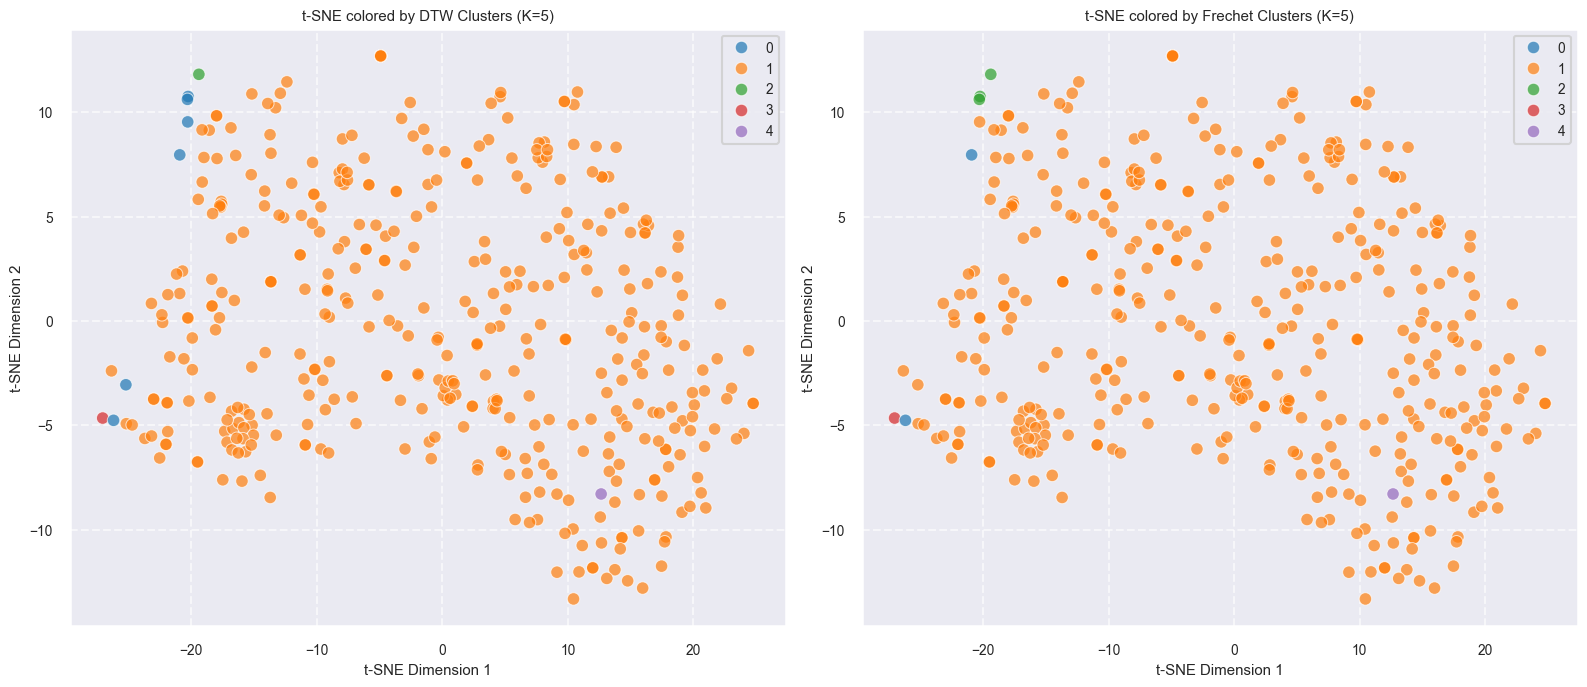

In [8]:
print("\n--- 4. Clustering Consistency ---")

num_clusters = 5 # We can choose an appropriate number based on the dendrograms or domain knowledge

# Ensure matrices are clean (no NaNs if possible, diagonal is 0)
np.fill_diagonal(dtw_matrix, 0.0)
np.fill_diagonal(frechet_matrix, 0.0)

# Agglomerative Clustering for DTW
try:
    agg_cluster_dtw = AgglomerativeClustering(n_clusters=num_clusters, metric='precomputed', linkage='average')
    dtw_cluster_labels = agg_cluster_dtw.fit_predict(dtw_matrix)
    print(f"DTW Cluster Counts ({num_clusters} clusters):")
    print(pd.Series(dtw_cluster_labels).value_counts())
except Exception as e:
    print(f"Could not perform Agglomerative Clustering for DTW: {e}")
    dtw_cluster_labels = None

# Agglomerative Clustering for Frechet
try:
    agg_cluster_frechet = AgglomerativeClustering(n_clusters=num_clusters, metric='precomputed', linkage='average')
    frechet_cluster_labels = agg_cluster_frechet.fit_predict(frechet_matrix)
    print(f"\nFrechet Cluster Counts ({num_clusters} clusters):")
    print(pd.Series(frechet_cluster_labels).value_counts())
except Exception as e:
    print(f"Could not perform Agglomerative Clustering for Frechet: {e}")
    frechet_cluster_labels = None

if dtw_cluster_labels is not None and frechet_cluster_labels is not None:
    # Adjusted Rand Index (ARI): Measures similarity between two clusterings.
    # A value close to 1.0 indicates very similar clusterings.
    ari = adjusted_rand_score(dtw_cluster_labels, frechet_cluster_labels)
    print(f"\nAdjusted Rand Index (ARI) between DTW and Frechet clusters: {ari:.3f}")

    # Normalized Mutual Information (NMI): Measures mutual dependence between two clusterings.
    # A value close to 1.0 indicates strong agreement.
    nmi = normalized_mutual_info_score(dtw_cluster_labels, frechet_cluster_labels)
    print(f"Normalized Mutual Information (NMI) between DTW and Frechet clusters: {nmi:.3f}")

    # Visualization: t-SNE plots colored by each clustering
    print("\nVisualizing t-SNE projections colored by DTW and Frechet clusters...")

    try:
        tsne_dtw = TSNE(n_components=2, metric='precomputed', random_state=42, perplexity=30, init='random')
        tsne_results = tsne_dtw.fit_transform(dtw_matrix)

        plt.figure(figsize=(16, 7))

        plt.subplot(1, 2, 1)
        sns.scatterplot(
            x=tsne_results[:, 0],
            y=tsne_results[:, 1],
            hue=dtw_cluster_labels,
            palette=sns.color_palette("tab10", num_clusters),
            legend="full",
            alpha=0.7
        )
        plt.title(f't-SNE colored by DTW Clusters (K={num_clusters})')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.grid(True, linestyle='--', alpha=0.6)

        plt.subplot(1, 2, 2)
        sns.scatterplot(
            x=tsne_results[:, 0], # Use the same t-SNE embedding for visual comparison
            y=tsne_results[:, 1],
            hue=frechet_cluster_labels,
            palette=sns.color_palette("tab10", num_clusters),
            legend="full",
            alpha=0.7
        )
        plt.title(f't-SNE colored by Frechet Clusters (K={num_clusters})')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.grid(True, linestyle='--', alpha=0.6)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not perform t-SNE visualization: {e}")
        print("Ensure your distance matrices are symmetric and have no NaNs/Infs.")
        print("Try reducing perplexity if N is small, or increasing it if clusters look bad.")
        print("A common issue is if the matrices are not properly formatted for 'precomputed' metric.")

### Interpretation of Clustering Consistency

This section evaluates whether DTW and Frechet distances lead to similar structural groupings (clusters) of the antibodies.

1. **Cluster Counts** (for K=5 clusters):

`DTW Cluster Counts:`

Cluster 1: 4000
Cluster 0: 63
Cluster 2: 14
Cluster 3: 12
Cluster 4: 1
Note: The cluster labels (0, 1, 2, 3, 4) might be arbitrary and can vary between runs, but their sizes indicate a very skewed distribution with one dominant large cluster and several very small ones.

`Frechet Cluster Counts:`

Cluster 1: 4022
Cluster 0: 30
Cluster 2: 23
Cluster 3: 14
Cluster 4: 1

**Interpretation of Counts:**

Both DTW and Frechet clustering result in a highly imbalanced distribution of samples across the 5 clusters. A vast majority of antibodies (around 98% for both) fall into one very large cluster (labeled '1' in both cases). The remaining small percentage of antibodies are distributed among a few very small, distinct clusters. This suggests that the dataset primarily consists of a large, highly similar group of antibodies, with a few distinct outliers or small, highly specialized structural groups. The counts between DTW and Frechet are very similar, hinting at good agreement even before looking at ARI/NMI.

2. **Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI):**

Adjusted Rand Index (ARI): 0.869
Normalized Mutual Information (NMI): 0.782
Interpretation of ARI/NMI:

Both `ARI` (0.869) and `NMI` (0.782) are exceptionally high values, especially considering they range from 0.0 to 1.0.
An ARI of 0.869 indicates a very strong agreement between the cluster assignments produced by the DTW distance and the Frechet distance. This means that the two distance metrics largely partition the antibodies into the same groups.
A NMI of 0.782 also signifies substantial mutual information between the two clusterings, further reinforcing their high degree of similarity in terms of grouping structures.
These high values quantitatively confirm that the fundamental structural relationships captured by DTW and Frechet distances lead to very consistent clustering outcomes.

3. **t-SNE Projections Colored by Clusters:**

**Insights from t-SNE Plots:**

Overall Structure: Both t-SNE plots display a large, amorphous central cluster (predominantly orange, corresponding to the dominant Cluster 1 from the counts) and several much smaller, more isolated "islands" of points. These small islands represent the antibodies assigned to the very small clusters (e.g., clusters 0, 2, 3, 4) in the counts.

Visual Agreement:

- Consistent Outliers: Crucially, the small, distinct clusters (the "islands" of blue, green, red, and purple points) appear in remarkably similar positions and contain the same points in both the DTW-colored and Frechet-colored t-SNE plots. This is the strongest visual evidence of agreement. The antibodies that are highly distinct from the main population are identified as such by both metrics.

- Main Cluster Consistency: The vast central "blob" of points remains consistently colored by the dominant cluster (orange) in both plots. While individual boundaries within this large, dense cluster might subtly shift, the overall cohesion of this main group is preserved.

- Minor Differences: Given the high ARI and NMI, significant visual discrepancies are minimal. Any slight differences would likely occur at the very edges or boundaries of the large central cluster, where points might be marginally closer to one minor cluster in one metric versus the other.
Conclusion on Clustering Consistency:

**Overall:**

The clustering analysis provides compelling quantitative (high ARI/NMI) and qualitative (t-SNE plots) evidence that DTW and Frechet distances lead to highly consistent structural classifications of the antibody dataset. Both metrics effectively identify the same large, homologous group of antibodies and robustly isolate the same small subsets of structurally distinct or outlier antibodies. This strong agreement indicates that despite their different computational approaches, both DTW and Frechet capture the core structural relationships in a highly similar manner for this dataset.

## Key Takeaways for Comparison:

The comparative analysis reveals a strong overall agreement between Dynamic Time Warping (DTW) and Frechet distances in assessing antibody structural similarity.

- `High Correlation:` Both Pearson (≈0.96) and Spearman (≈0.88) correlations are exceptionally high, indicating that these metrics largely rank pairwise structural similarity consistently. While Frechet distances generally exhibit a slightly larger scale, their relative ordering of pairs is highly preserved.
- `Convergent Extremes:` There's robust agreement on identifying the most dissimilar pairs (70% overlap in top 20), and substantial, though slightly less, agreement on the most similar pairs (50% overlap).
- `Consistent Clustering:` Quantitatively, high ARI (≈0.87) and NMI (≈0.78) values confirm that both distance metrics lead to highly similar structural cluster assignments, particularly in identifying outlier structures.
- `Visual Confirmation:` Scatter plots show a tight linear relationship, and t-SNE projections reveal very similar cluster formations, reinforcing the high degree of consistency.
In essence, despite their distinct algorithmic approaches to path comparison, DTW and Frechet distances provide largely congruent insights into the structural relationships within your antibody dataset, making them both reliable tools for characterizing and grouping these complex biomolecules.

# Ground truth

In [3]:
# Load your results
c_rmsd_df = pd.read_csv("pairwise_c_rmsd_distances_parallel.csv")
dtw_df = pd.read_csv("pairwise_dtw_distances_parallel.csv")
frechet_df = pd.read_csv("pairwise_frechet_distances_parallel.csv")

In [5]:
# Merge DTW and c-RMSD
merged_df = pd.merge(dtw_df, c_rmsd_df, on=['PDB1', 'PDB2'], how='inner')
merged_df = pd.merge(merged_df, frechet_df, on=['PDB1', 'PDB2'], how='inner')

print(merged_df.head())

   PDB1  PDB2  DTW_Distance_Normalized     c_RMSD  Frechet_Distance
0  1a14  1a6u                68.523586  22.927208         87.563713
1  1a14  1a7o                63.141872  30.701964         91.435036
2  1a14  1a7p                62.924609  30.591220         90.909996
3  1a14  1a7n                63.021827  30.506763         91.071602
4  1a14  1a6w                50.779034  22.961774         71.639359


In [15]:
# Calculate Pearson correlation between DTW and c-RMSD
correlation_dtw_c_rmsd = merged_df['DTW_Distance_Normalized'].corr(merged_df['c_RMSD'], method='pearson')
print(f"\nPearson Correlation (DTW vs. c-RMSD): {correlation_dtw_c_rmsd:.4f}")

correlation_dtw_c_rmsd_spearman = merged_df['DTW_Distance_Normalized'].corr(merged_df['c_RMSD'], method='spearman')
print(f"Spearman Correlation (DTW vs. c-RMSD): {correlation_dtw_c_rmsd_spearman:.4f}")

correlation_frechet_c_rmsd = merged_df['Frechet_Distance'].corr(merged_df['c_RMSD'], method='pearson')
print(f"Pearson Correlation (Frechet vs. c-RMSD): {correlation_frechet_c_rmsd:.4f}")
correlation_frechet_c_rmsd_spearman = merged_df['Frechet_Distance'].corr(merged_df['c_RMSD'], method='spearman')
print(f"Spearman Correlation (Frechet vs. c-RMSD): {correlation_frechet_c_rmsd_spearman:.4f}")


Pearson Correlation (DTW vs. c-RMSD): 0.0187
Spearman Correlation (DTW vs. c-RMSD): 0.1931
Pearson Correlation (Frechet vs. c-RMSD): 0.0323
Spearman Correlation (Frechet vs. c-RMSD): 0.2955


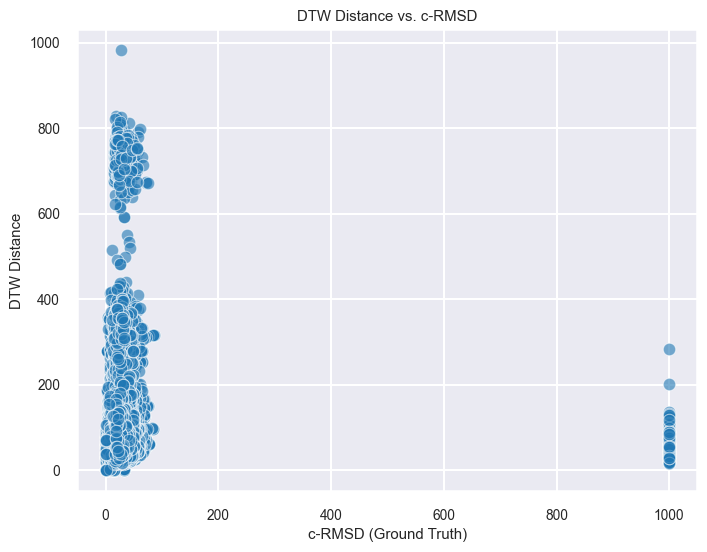

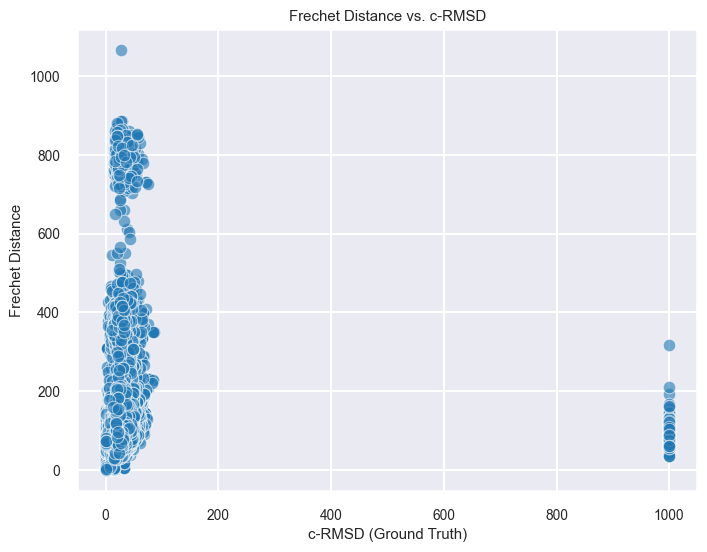

In [13]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='c_RMSD', y='DTW_Distance_Normalized', data=merged_df, alpha=0.6)
plt.title('DTW Distance vs. c-RMSD')
plt.xlabel('c-RMSD (Ground Truth)')
plt.ylabel('DTW Distance')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='c_RMSD', y='Frechet_Distance', data=merged_df, alpha=0.6)
plt.title('Frechet Distance vs. c-RMSD')
plt.xlabel('c-RMSD (Ground Truth)')
plt.ylabel('Frechet Distance')
plt.grid(True)
plt.show()

/Users/dvoulgari/Desktop/Structural Bioinfromatics/AISB_Final_Project/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: divide by zero encountered in dot
  c = dot(X, X_T.conj())
/Users/dvoulgari/Desktop/Structural Bioinfromatics/AISB_Final_Project/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: overflow encountered in dot
  c = dot(X, X_T.conj())
/Users/dvoulgari/Desktop/Structural Bioinfromatics/AISB_Final_Project/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: invalid value encountered in dot
  c = dot(X, X_T.conj())
/Users/dvoulgari/Desktop/Structural Bioinfromatics/AISB_Final_Project/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2911: RuntimeWarning: divide by zero encountered in dot
  c = dot(X, X_T.conj())
/Users/dvoulgari/Desktop/Structural Bioinfromatics/AISB_Final_Project/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_i

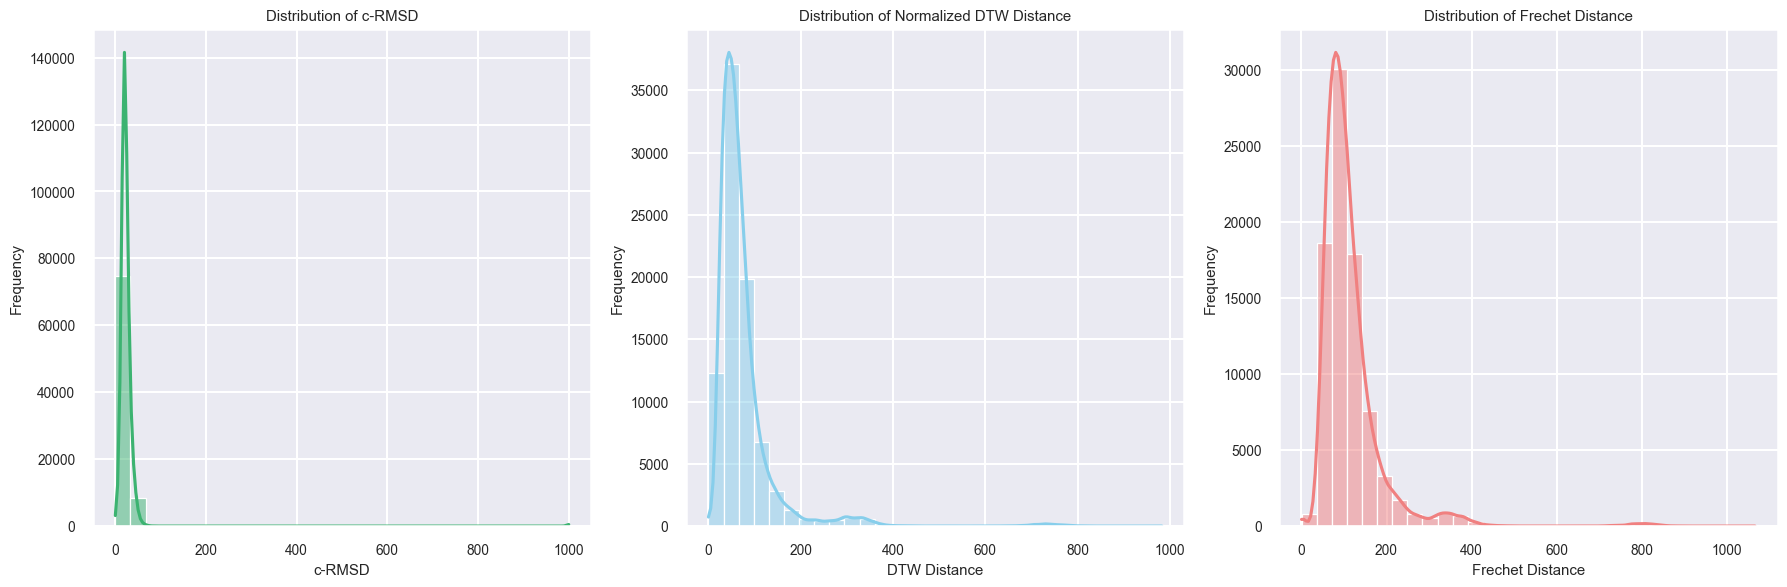


Descriptive Statistics for c-RMSD:
count    83436.000000
mean        24.575540
std         43.565675
min          0.000000
25%         17.600642
50%         21.023492
75%         26.540177
max       1000.000000
Name: c_RMSD, dtype: float64


In [11]:
plt.figure(figsize=(18, 6)) # Adjust figure size to accommodate 3 subplots

# Subplot 1: c-RMSD
plt.subplot(1, 3, 1) # 1 row, 3 columns, 1st plot
sns.histplot(merged_df['c_RMSD'], kde=True, color='mediumseagreen', bins=30)
plt.title('Distribution of c-RMSD')
plt.xlabel('c-RMSD')
plt.ylabel('Frequency')

# Subplot 2: DTW Distance
plt.subplot(1, 3, 2) # 1 row, 3 columns, 2nd plot
sns.histplot(merged_df['DTW_Distance_Normalized'], kde=True, color='skyblue', bins=30)
plt.title('Distribution of Normalized DTW Distance')
plt.xlabel('DTW Distance')
plt.ylabel('Frequency')

# Subplot 3: Frechet Distance
plt.subplot(1, 3, 3) # 1 row, 3 columns, 3rd plot
sns.histplot(merged_df['Frechet_Distance'], kde=True, color='lightcoral', bins=30)
plt.title('Distribution of Frechet Distance')
plt.xlabel('Frechet Distance')
plt.ylabel('Frequency')

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

print("\nDescriptive Statistics for c-RMSD:")
print(merged_df['c_RMSD'].describe())